In [1]:
!./download_weights.sh

Model weights already downloaded.


In [2]:
RGB_MEAN = [103.939,116.779,123.68, 137.86]
#RGB_MEAN = [104,115,124, 138]

HEIGHT  = 400 # Must be a multiple of 16
WIDTH   = 400 
INPUT_SHAPE = (HEIGHT, WIDTH, 3)
INPUT_SHAPE_WITH_BATCH = (None, HEIGHT, WIDTH, 3)

WEIGHTS_PATH = "weights/DexiNed23_model.h5"

DATA_PATH = "test_data"

SAVEDMODEL_MODEL_NAME = "SavedModel/DexiNed"

In [3]:
import os
import io

import numpy as np
import tensorflow as tf

from PIL import Image

from model import DexiNed
from utils import image_normalization

In [4]:
cwd = os.getcwd()

In [5]:
def build_model():
    weights_path = os.path.join(cwd, WEIGHTS_PATH)
    return build_original_model_with_weights(weights_path)

def build_original_model_with_weights(weights_path):
    model = DexiNed(rgb_mean=RGB_MEAN)
    model.build(input_shape=INPUT_SHAPE_WITH_BATCH)
    model.load_weights(weights_path)
    
    return model

def build_model_with_preprocessing(height = HEIGHT, width = WIDTH):
    inputs = tf.keras.Input(shape=(height, width, 3), name = "input_image")
    
    preprocessing_layers = tf.keras.layers.experimental.preprocessing.Resizing(height = HEIGHT, width = WIDTH)
    original_model = build_model()
    
    x = preprocessing_layers(inputs)
    outputs = original_model(x, training=False)
    
    model = tf.keras.Model(inputs, outputs)
    
    return model

In [6]:
def save_model(model, path):
    saved_model_path = os.path.join(cwd, path)
    model.save(saved_model_path)

model1 = build_model_with_preprocessing()
model1.summary()

#save_model(model1, SAVEDMODEL_MODEL_NAME)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 400, 400, 3)]     0         
_________________________________________________________________
resizing (Resizing)          (None, 400, 400, 3)       0         
_________________________________________________________________
dexi_ned (DexiNed)           [(None, 400, 400, 1), (No 35238475  
Total params: 35,238,475
Trainable params: 35,214,475
Non-trainable params: 24,000
_________________________________________________________________


In [7]:
def run_image(image, should_display_results = False):
    height, width, _ = np.shape(image)
    
    x = np.asarray(image, dtype=np.float32)
    #x = resize_image_if_needed(x)
    
    model = build_model_with_preprocessing(height, width)
    
    print(model.summary())
    
    edges = run_full_model(model, x)
    
    if should_display_results:
        display_results(edges, "Full Model")
    
    tflite_model = convert_keras_to_tflite_model(model)
    tflite_model_path = os.path.join(cwd, "model.tflite")

    save_tflite_model(tflite_model, tflite_model_path)
    edges = run_tflite_model(tflite_model_path, x)
    
    if should_display_results:
        display_results(edges, "Lite Model")
        
def resize_image_if_needed(image):
    h, w = np.shape(image)[:2]
    if h != HEIGHT or w != WIDTH:
        image = tf.image.resize(image, [WIDTH, HEIGHT])
        
    return image
    
def run_full_model(model, image_tensor):
    print("Running Full Model")
    
    image_tensor = np.expand_dims(image_tensor, axis=0)
    preds = model(image_tensor)
    
    return process_model_output(preds)

def process_model_output(preds):
    preds = [tf.sigmoid(i).numpy() for i in preds]
        
    SAVE_DIRS = 3
    tmp_shape = INPUT_SHAPE
    all_preds = np.array(preds)
    images_to_return = []
    for i in range(all_preds.shape[1]):
        tmp_preds = all_preds[:, i, ...]
        tmp_av = tf.expand_dims(tmp_preds.mean(axis=0), axis=0)
        tmp_preds = tf.concat((tmp_preds, tmp_av), axis=0)
        tmp_preds = np.array(tmp_preds)
        res_preds = []
        for j in range(tmp_preds.shape[0]):
            tmp_pred = tmp_preds[j, ...]
            tmp_pred[tmp_pred < 0.0] = 0.0
            tmp_pred = tf.bitwise.invert(tf.cast(image_normalization(tmp_pred), tf.uint8))
            h, w = tmp_pred.shape[:2]

            if h != tmp_shape[0] or w != tmp_shape[1]:
                tmp_pred = tf.cast(tf.image.resize(tmp_pred, (tmp_shape[1], tmp_shape[0])), tf.uint8)
            res_preds.append(tmp_pred)
        n_save =len(tmp_preds)-2
        for idx in range(SAVE_DIRS - 1):
            tmp = res_preds[n_save + idx]
            tmp = tf.io.encode_png(tmp)
            
            images_to_return.append(tmp)
            
    return images_to_return

def display_results(images, model_name):
    for idx, image in enumerate(images):
        print(f'Displaying image #{idx} for model {model_name}')
        
        tmp_file_path = f'./data/ouput_image_{model_name}_{idx}.png'

        file_name = tf.constant(tmp_file_path)
        file = tf.io.write_file(file_name, image)

        output_image = Image.open(tmp_file_path)
        output_image.show()
    
        os.remove(tmp_file_path)

In [8]:
def convert_keras_to_tflite_model(keras_model):
    print("Converting TF Lite Model")
    
    converter = tf.lite.TFLiteConverter.from_keras_model(keras_model)
    tflite_model = converter.convert()
    
    return tflite_model

def save_tflite_model(tflite_model, file_path):
    os.remove(file_path)
    
    with open(file_path, 'wb') as f:
        f.write(tflite_model)
    
def run_tflite_model(tflite_model_path, *args):
    print("Running TF Lite Model")
    
    interpreter = tf.lite.Interpreter(model_path=str(tflite_model_path))
    
    inputs_details = interpreter.get_input_details()
    outputs_details = interpreter.get_output_details()
    
    interpreter.allocate_tensors()

    for idx, input_details in enumerate(inputs_details):
        model_input = args[idx]
        # Check if the input type is quantized, then rescale input data to uint8
        if input_details['dtype'] == np.uint8:
            input_scale, input_zero_point = input_details["quantization"]
            model_input = model_input / input_scale + input_zero_point
            
        model_input = np.expand_dims(model_input, axis=0).astype(input_details["dtype"])
        interpreter.set_tensor(input_details["index"], model_input)
    
    interpreter.invoke()
    
    output = ([np.array(interpreter.get_tensor(output_details["index"])).astype(output_details["dtype"]) for output_details in outputs_details])
    
    return process_model_output(output)

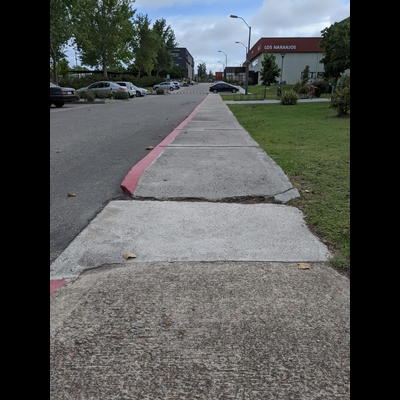

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 400, 400, 3)]     0         
_________________________________________________________________
resizing_1 (Resizing)        (None, 400, 400, 3)       0         
_________________________________________________________________
dexi_ned_1 (DexiNed)         [(None, 400, 400, 1), (No 35238475  
Total params: 35,238,475
Trainable params: 35,214,475
Non-trainable params: 24,000
_________________________________________________________________
None
Running Full Model
Displaying image #0 for model Full Model


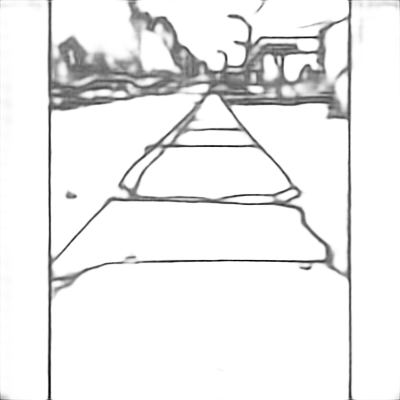

Displaying image #1 for model Full Model


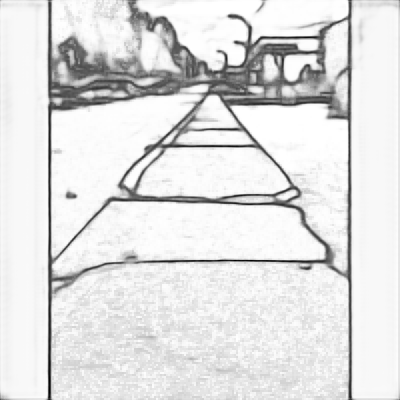

Converting TF Lite Model


INFO:tensorflow:Assets written to: /tmp/tmp_dcuo1q4/assets


INFO:tensorflow:Assets written to: /tmp/tmp_dcuo1q4/assets


Running TF Lite Model
Displaying image #0 for model Lite Model


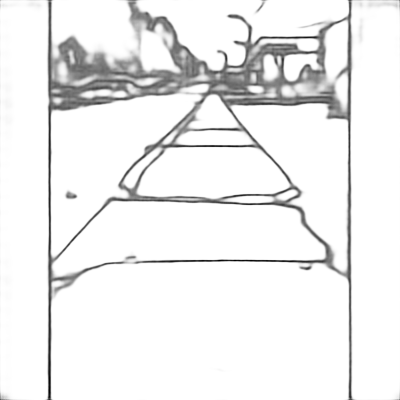

Displaying image #1 for model Lite Model


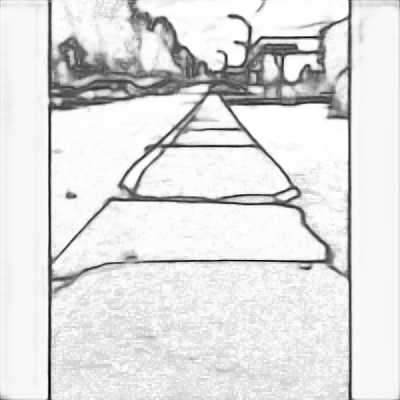

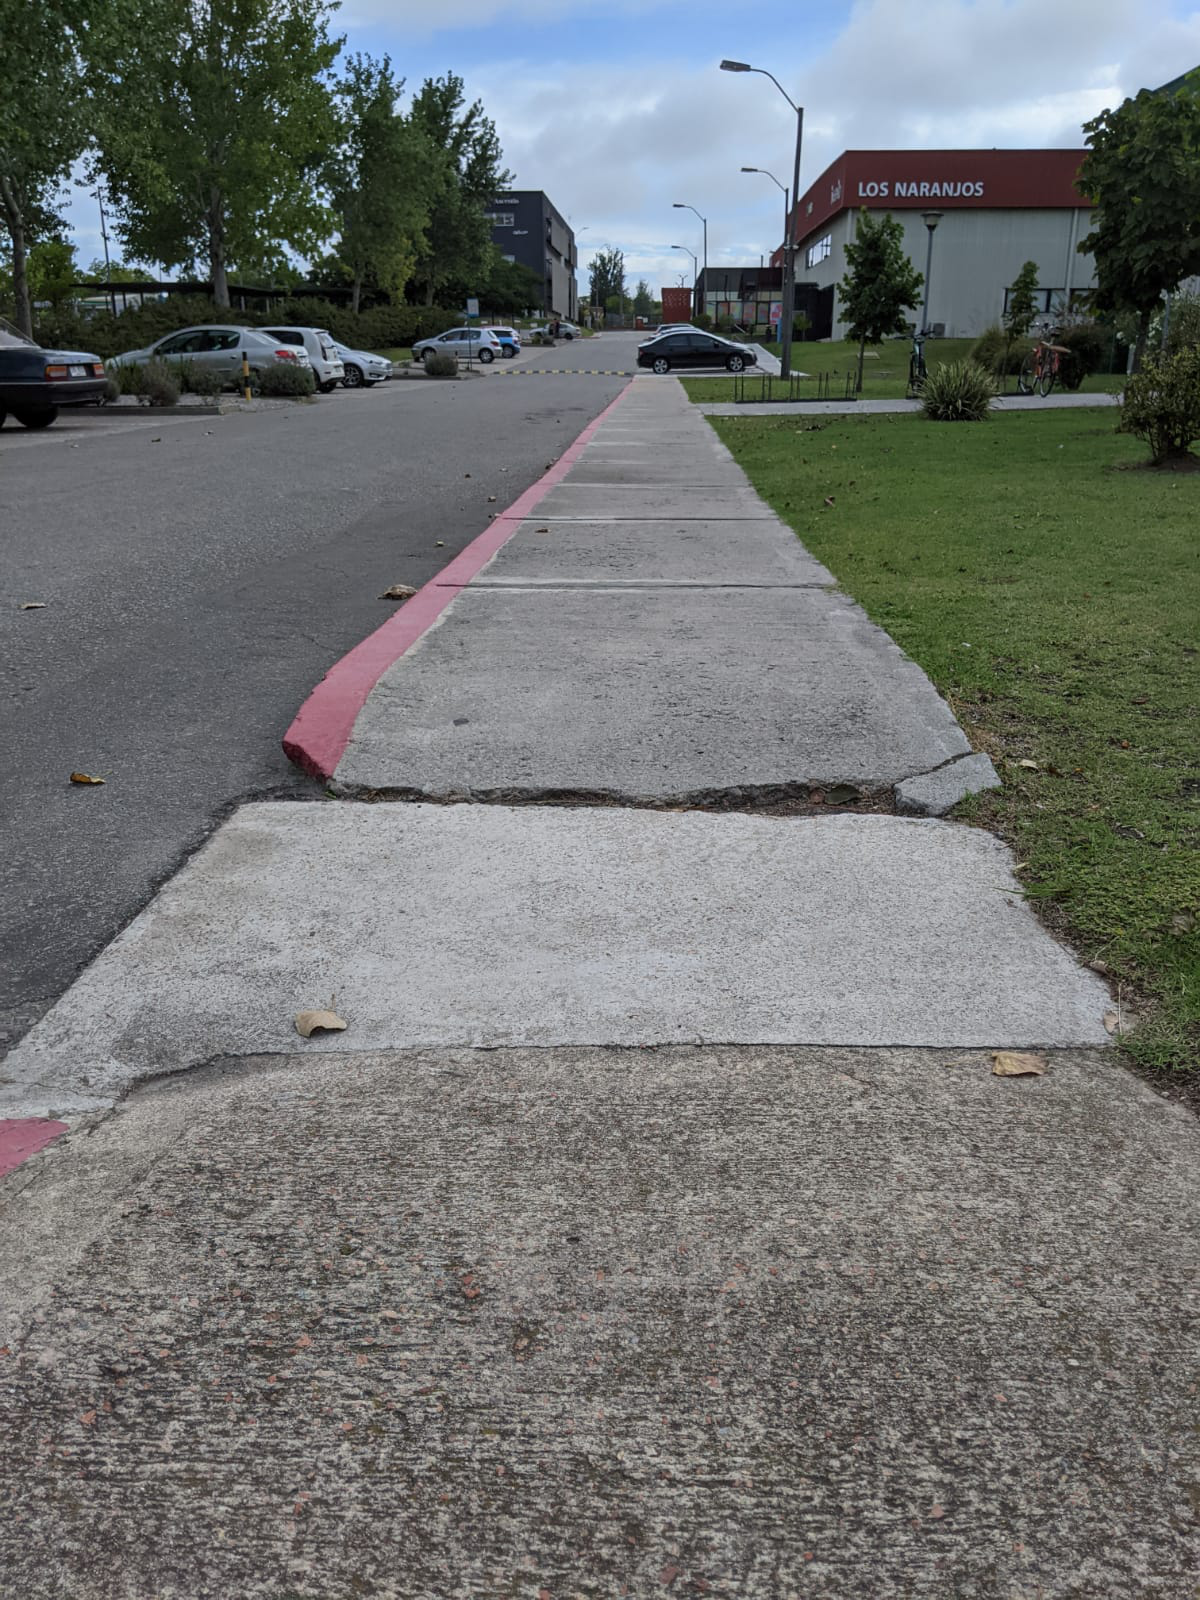

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 1600, 1200, 3)]   0         
_________________________________________________________________
resizing_2 (Resizing)        (None, 400, 400, 3)       0         
_________________________________________________________________
dexi_ned_2 (DexiNed)         [(None, 400, 400, 1), (No 35238475  
Total params: 35,238,475
Trainable params: 35,214,475
Non-trainable params: 24,000
_________________________________________________________________
None
Running Full Model
Displaying image #0 for model Full Model


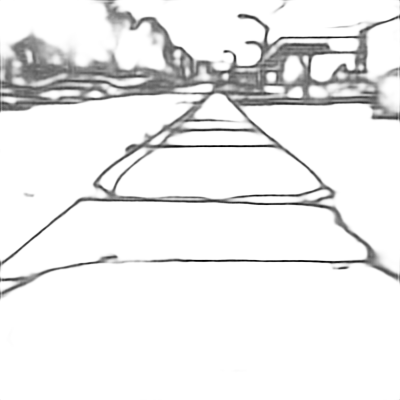

Displaying image #1 for model Full Model


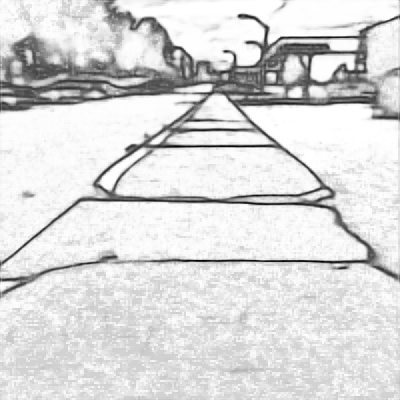

Converting TF Lite Model


INFO:tensorflow:Assets written to: /tmp/tmpqs8g0311/assets


INFO:tensorflow:Assets written to: /tmp/tmpqs8g0311/assets


Running TF Lite Model
Displaying image #0 for model Lite Model


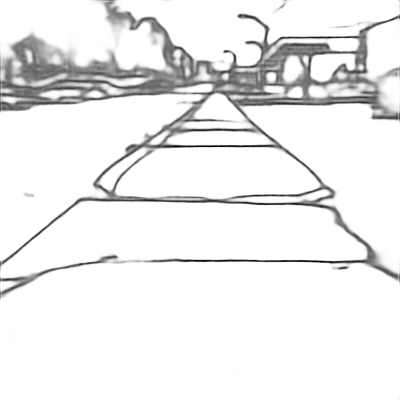

Displaying image #1 for model Lite Model


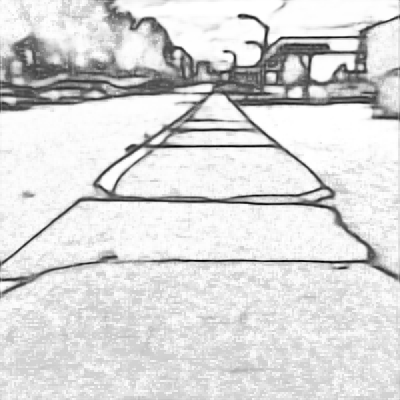

In [9]:
image_resized_path = os.path.join(cwd, DATA_PATH, "test_image_resized.png")
image_path = os.path.join(cwd, DATA_PATH, "test_image.jpg")

# Resized (padded) image
image = Image.open(image_resized_path)
image.show()

run_image(image, should_display_results = True)

# Non-resized image
image = Image.open(image_path)
image.show()

run_image(image, should_display_results = True)